# Check Data Quality 

##  Imports

In [222]:
from scipy.io import wavfile
import tgt
import re
import collections
import os
import pandas as pd
import textgrids
import glob
import ipapy
from ipapy.ipachar import IPAVowel
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
import numpy as np
from pydub import AudioSegment,silence
import librosa
import librosa.display
import textgrids
import seaborn as sns
import scipy
import numba 
from numba import jit
import time

### Import data 

In [15]:
with open("./downsampled_audio/downsampled_audio_dictionary", "rb+") as f:
    downsample_dictionary = pickle.load(f)

In [16]:
with open("df_w_features", "rb+") as f:
    final_df = pickle.load(f)

In [17]:
downsample_dictionary

{'ENF_02': {'original': array([-0.06265225,  0.06265275, -0.06265325, ...,  0.06265075,
         -0.06265125,  0.06265175]),
  'Filter_25': (array([-0.06265225,  0.06265275, -0.06265325, ...,  0.06265075,
          -0.06265125,  0.06265175]),
   [16291,
    16293,
    20773,
    20774,
    22748,
    22749,
    22750,
    23489,
    23490,
    23491,
    23492,
    23493,
    23900,
    23901,
    23902,
    23903,
    23904,
    23905,
    24177,
    24178,
    24179,
    24180,
    24217,
    24218,
    24219,
    24220,
    24221,
    24222,
    24259,
    24260,
    24261,
    25022,
    25023,
    25817,
    25818,
    25959,
    25960,
    25961,
    26450,
    26451,
    26452,
    26453,
    26507,
    26508,
    26509,
    26510,
    26645,
    26646,
    26647,
    26648,
    32832,
    32836,
    34373,
    37428,
    37429,
    37430,
    37431,
    37525,
    37857,
    37858,
    37859,
    37860,
    37861,
    38253,
    38254,
    38255,
    38646,
    38647,
    38842

In [13]:
final_df

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Approximant,Liquid,Nasal,Fricative,Stop,Voiced,Speaker,Phone_Duration
0,NaN,0.000000,2.000000,NaN,0.000000,2.000000,0,0,0,0,0,0,0,0,08,2.000000
1,!SIL,2.000000,5.819875,!SIL,2.000000,5.828022,0,0,0,0,0,0,0,0,08,3.819875
2,IY,5.819875,6.229875,!SIL,2.000000,5.828022,1,1,0,0,0,0,0,0,08,0.410000
3,EH,6.229875,6.619875,!SIL,2.000000,5.828022,1,1,0,0,0,0,0,0,08,0.390000
4,N,6.619875,7.109875,!SIL,2.000000,5.828022,0,1,0,0,1,0,0,1,08,0.490000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DD,583.808250,584.088250,good,583.588250,584.088250,0,1,0,0,0,0,1,1,14,0.280000
1616,Y,584.088250,584.118250,yay,584.088250,584.569608,0,1,1,0,0,0,0,1,14,0.030000
1617,AE,584.118250,584.548250,yay,584.088250,584.569608,1,1,0,0,0,0,0,0,14,0.430000
1618,!SIL,584.548250,584.815063,yay,584.088250,584.569608,0,0,0,0,0,0,0,0,14,0.266813


# Initial EDA

## How many unique phones are there?

In [9]:
unique_phone_list = []
for df in textgrid_dfs:
    for item in df['Phone_Text'].unique():
        if item not in unique_phone_list:
            unique_phone_list.append(item)

In [10]:
len(unique_phone_list)

55

In [11]:
unique_phone_list[0:3]

[nan, '!SIL', 'IY']

In [12]:
str_phones = [x for x in unique_phone_list if type(x) == str]

In [13]:
lower_case_phones = [x for x in str_phones if x.lower() == x]
lower_case_phones

['lg', 'ls', 'br', 'ga']

In [14]:
lower_case_phones_meanings = {"ls": "lip smack","ga": 'garbage (non-speech)','lg': 'laughter','br': "breaths/sighs"}

In [15]:
speech_sounds = [x for x in str_phones if x not in lower_case_phones]
speech_sounds.remove('!SIL')

## Get examples of each vowel 

In [16]:
ortho_vowels = ['a', 'e', 'i', 'o', 'u']
vowels = [x for x in speech_sounds if x[0].lower() in ortho_vowels]

In [17]:
len(vowels)

18

In [18]:
for thing in textgrid_dfs[0].values:
    print(thing[0])

nan
!SIL
IY
EH
N
Z
IH
R
OW
EY
TD
!SIL
M
M
!SIL
DH
EH
R
Z
N
OW
N
EY
M
AX
TD
JH
AX
S
TD
L
UH
K
S
L
AY
KD
AH
AX
TD
HH
AX
Z
AX
M
AA
R
G
AXR
IY
DX
AX
G
L
AE
S
!SIL
AO
L
R
AY
TD
!SIL
OW
K
EY
B
AO
S
AX
Z
B
UW
Z
!SIL
L
EH
TD
M
IY
AY
W
AA
N
AY
W
AA
N
AX
CH
EY
N
JH
DH
AE
TD
AX
TS
AX
T
AE
K
W
IY
L
AX
G
L
AE
S
DH
AX
TD
HH
AE
Z
AX
L
AY
M
AX
N
DH
AX
G
L
AE
S
!SIL
Y
AE
!SIL
AH
N
OW
AX
TS
L
AY
KD
IH
IY
IH
IY
!SIL
Y
AE
Y
AE
S
T
EH
M
!SIL
AX
N
DD
DH
EH
N
DH
AE
TD
S
EY
M
B
IH
L
D
IX
NG
DH
EH
R
AXR
D
AO
R
Z
!SIL
AH
JH
AX
S
TD
DH
AH
F
L
AE
PD
D
AO
R
Z
!SIL
AE
N
DD
W
IH
N
D
OW
Z
!SIL
AO
R
AX
N
JH
F
AO
R
P
EY
N
DD
W
IH
N
D
OW
Z
Y
AE
!SIL
IX
G
Z
AE
KD
TD
L
IY
!SIL
DH
IY
B
IH
L
D
IX
NG
AX
Z
Y
EH
L
OW
DH
IY
AH
T
R
IH
M
AH
V
DH
AX
B
IH
L
D
IX
NG
W
AX
DH
AX
L
IH
DX
AX
L
R
UW
F
OW
V
AXR
DH
AH
F
R
AH
N
TD
D
AO
R
AX
Z
B
R
AW
N
!SIL
AH
DH
AX
W
IH
N
D
OW
Z
AXR
AO
R
AX
N
JH
AX
N
DD
DH
EH
N
DH
AX
S
AY
N
AA
N
T
AA
PD
IH
Z
P
IH
L
AY
KD
M
AXR
UW
N
AX
N
DD
P
ER
P
AX
L
!SIL
Y
AE
DH
EH
R
AXR
S
EH
V
AX
N
L
AY
TS
!SIL
OW
K
EY
!

In [19]:
# getting example words for each vowel
example_vowel_words = []
for item in vowels:
    counter = 0
    for thing in textgrid_dfs[0].values:
        if thing[0] == item:
            counter += 1
            if counter > 5:
                example_vowel_words.append((item, thing[3]))
                break

In [20]:
example_vowel_words[0]

('IY', 'i-')

## Vowel Dict
- https://tophonetics.com
- https://github.com/pettarin/ipapy

In [21]:
vowels_dict = {x:None for x in vowels}

In [22]:
vowels_dict['IH'] = u"ɪ"
vowels_dict['OW'] = u"oʊ"
vowels_dict['EY'] = u"eɪ"
vowels_dict['UH'] = u"ʊ"
vowels_dict['AY'] = u"aɪ"
vowels_dict['AH'] = u"ʌ"
vowels_dict['AE'] = u"æ"
vowels_dict['AO'] = u"ɔ"
vowels_dict['AA'] = u"ɑ"
vowels_dict['AX'] = u"æ"
vowels_dict['UW'] = u"u"
vowels_dict['IX'] = u"ɪ"
vowels_dict['AW'] = u"aʊ"
vowels_dict['ER'] = u"ɜ"
vowels_dict['OY'] = u"ɔɪ"

In [23]:
# vowels_dict

In [24]:
vowels_dict['IY'] = u"i"
vowels_dict['AXR'] = u"ə"
vowels_dict['EH'] = u"ɛ"

## Getting examples of each consonant

In [25]:
consonants = [x for x in speech_sounds if x not in vowels]

In [26]:
# getting example words for each consonant
example_cons_words = []
for item in consonants:
    counter = 0
    for thing in textgrid_dfs[0].values:
        if thing[0] == item:
            counter += 2
            if counter > 5:
                example_cons_words.append((item, thing[3]))
                break

In [27]:
example_cons_words[0]

('N', 'name')

## Column functions

### Cons / Vowel

In [28]:
consonants = [x for x in speech_sounds if x not in vowels]

In [29]:
def add_vowel_col(df, vowels = vowels):
    vowel_col = []
    for item in df['Phone_Text']:
        if item in vowels:
            vowel_col.append(1)
        else:
            vowel_col.append(0)
    df['Vowel'] = vowel_col
    return df

In [30]:
test_df = add_vowel_col(textgrid_dfs[0])

### Speech Sounds

In [31]:
speech_sounds = [x for x in str_phones if x.upper() == x and "!" not in x[0]]

In [32]:
def add_speech_sound_col(df, speech_sounds = speech_sounds):
    speech_sound_col = []
    for item in df['Phone_Text']:
        if item in speech_sounds:
            speech_sound_col.append(1)
        else:
            speech_sound_col.append(0)
    df['Speech_Sound'] = speech_sound_col
    return df

In [33]:
test_df1 = add_speech_sound_col(test_df)

### Adding speaker name to df 

In [34]:
def get_speaker_name(df_list, textgrid_names_list = textgrid_names_list):
    new_df_list = []
    for index, df in enumerate(df_list):
        df['Speaker'] = textgrid_names_list[index][-10:-8]
        new_df_list.append(df)
    return new_df_list

In [35]:
def add_dummies_to_dfs(df):
    approximant = ['W', 'Y']
    liquid = ['R', 'L']
    nasal = ['M', 'N', 'NG']
    fricative = ['Z', 'DH', "TH", "SH", "S", 'HH', "F", 'V']
    stop = ['P', "PD", "T", "TD", "K", "KD", "B", "G", 'DX', "CH", "DD", "DX", "TS", "JH"]
    voiced = approximant + liquid + nasal + ['Z', 'DH', 'V', "B", "G", 'DX', "DD", "DX", "JH"]
    # adding dummies for each sound class 
    df['Approximant'] = [1 if x in approximant else 0 for x in df['Phone_Text'] ]
    df['Liquid'] = [1 if x in liquid else 0 for x in df['Phone_Text'] ]
    df['Nasal'] = [1 if x in nasal else 0 for x in df['Phone_Text'] ]
    df['Fricative'] = [1 if x in fricative else 0 for x in df['Phone_Text'] ]
    df['Stop'] = [1 if x in stop else 0 for x in df['Phone_Text'] ]
    df['Voiced'] = [1 if x in voiced else 0 for x in df['Phone_Text'] ]
    return df

In [36]:
def add_cols_to_dfs(df_list):
    new_df_list = []
    for df in df_list:
        df = add_vowel_col(df)
        df = add_speech_sound_col(df)
        df = add_dummies_to_dfs(df)
        new_df_list.append(df)
    return new_df_list

## Running the Functions

In [37]:
new_textgrid_dfs = add_cols_to_dfs(textgrid_dfs)

In [38]:
new_textgrid_dfs[0]

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Approximant,Liquid,Nasal,Fricative,Stop,Voiced
0,NaN,0.000000,2.000000,NaN,0.000000,2.000000,0,0,0,0,0,0,0,0
1,!SIL,2.000000,5.819875,!SIL,2.000000,5.828022,0,0,0,0,0,0,0,0
2,IY,5.819875,6.229875,!SIL,2.000000,5.828022,1,1,0,0,0,0,0,0
3,EH,6.229875,6.619875,!SIL,2.000000,5.828022,1,1,0,0,0,0,0,0
4,N,6.619875,7.109875,!SIL,2.000000,5.828022,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,!SIL,346.547500,368.229875,!SIL,346.547500,368.211117,0,0,0,0,0,0,0,0
2094,HH,368.229875,368.329875,!SIL,346.547500,368.211117,0,1,0,0,0,1,0,0
2095,M,368.329875,368.369875,!SIL,346.547500,368.211117,0,1,0,0,1,0,0,1
2096,!SIL,368.369875,368.495026,!SIL,346.547500,368.211117,0,0,0,0,0,0,0,0


In [39]:
final_textgrid_dfs = get_speaker_name(new_textgrid_dfs)

## Saving the new dataframes in a single df

In [40]:
final_empty_df = pd.DataFrame()
final_df = final_empty_df.append(final_textgrid_dfs)

In [41]:
final_df

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Approximant,Liquid,Nasal,Fricative,Stop,Voiced,Speaker
0,NaN,0.000000,2.000000,NaN,0.000000,2.000000,0,0,0,0,0,0,0,0,08
1,!SIL,2.000000,5.819875,!SIL,2.000000,5.828022,0,0,0,0,0,0,0,0,08
2,IY,5.819875,6.229875,!SIL,2.000000,5.828022,1,1,0,0,0,0,0,0,08
3,EH,6.229875,6.619875,!SIL,2.000000,5.828022,1,1,0,0,0,0,0,0,08
4,N,6.619875,7.109875,!SIL,2.000000,5.828022,0,1,0,0,1,0,0,1,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,DD,583.808250,584.088250,good,583.588250,584.088250,0,1,0,0,0,0,1,1,14
1616,Y,584.088250,584.118250,yay,584.088250,584.569608,0,1,1,0,0,0,0,1,14
1617,AE,584.118250,584.548250,yay,584.088250,584.569608,1,1,0,0,0,0,0,0,14
1618,!SIL,584.548250,584.815063,yay,584.088250,584.569608,0,0,0,0,0,0,0,0,14


with open("en-en_textgrid_data", 'wb+') as f:
    pickle.dump(final_df, f)

# EDA for Data Filtering 

## Count of all vowels  

In [42]:
# counting how many vowels there are in total:
total_vowels = 0
counter = 0
for df in final_textgrid_dfs:
    count = df.Vowel.sum()
    print(f"df {counter} has {count} vowels")
    counter += 1
    total_vowels += count
print(f"There are {total_vowels} in total")

df 0 has 801 vowels
df 1 has 593 vowels
df 2 has 761 vowels
df 3 has 806 vowels
df 4 has 1347 vowels
df 5 has 434 vowels
df 6 has 389 vowels
df 7 has 485 vowels
df 8 has 1219 vowels
df 9 has 642 vowels
df 10 has 632 vowels
df 11 has 321 vowels
df 12 has 723 vowels
df 13 has 709 vowels
df 14 has 414 vowels
df 15 has 578 vowels
There are 10854 in total


In [43]:
final_df.Speaker.unique()

array(['08', '09', '14', '06', '13', '03', '17', '02', '07', '11', '05',
       '18', '10'], dtype=object)

## Counting silent intervals 

In [44]:
# how many truly silent intervals are there?
silent_df = final_df[(final_df['Phone_Text'] == "!SIL") & (final_df['Word_Text'] == "!SIL")]

In [45]:
silent_df.shape

(1170, 15)

## Adding phone duration column

In [46]:
final_df['Phone_Duration'] = np.where((final_df['Phone_xmax'] - final_df['Phone_xmin']) > 0, 
                                     (final_df['Phone_xmax'] - final_df['Phone_xmin']),
                                     np.nan)

In [47]:
final_df.tail()

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Approximant,Liquid,Nasal,Fricative,Stop,Voiced,Speaker,Phone_Duration
1615,DD,583.808250,584.088250,good,583.588250,584.088250,0,1,0,0,0,0,1,1,14,0.280000
1616,Y,584.088250,584.118250,yay,584.088250,584.569608,0,1,1,0,0,0,0,1,14,0.030000
1617,AE,584.118250,584.548250,yay,584.088250,584.569608,1,1,0,0,0,0,0,0,14,0.430000
1618,!SIL,584.548250,584.815063,yay,584.088250,584.569608,0,0,0,0,0,0,0,0,14,0.266813
1619,!SIL,584.815057,586.815057,yay,584.815057,586.815057,0,0,0,0,0,0,0,0,14,2.000000


In [48]:
final_df.Phone_Text.unique()

array([nan, '!SIL', 'IY', 'EH', 'N', 'Z', 'IH', 'R', 'OW', 'EY', 'TD',
       'M', 'DH', 'AX', 'JH', 'S', 'L', 'UH', 'K', 'AY', 'KD', 'AH', 'HH',
       'AA', 'G', 'AXR', 'DX', 'AE', 'AO', 'B', 'UW', 'W', 'CH', 'TS',
       'T', 'Y', 'DD', 'D', 'IX', 'NG', 'F', 'PD', 'P', 'V', 'AW', 'ER',
       'SH', 'TH', 'OY', 'GD', 'lg', 'ls', 'br', 'ga', 'BD'], dtype=object)

## What is the duration range for vowels

In [49]:
vowel_df = final_df[final_df['Vowel'] == 1].reset_index()

In [50]:
vowel_df.tail()

,index,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Approximant,Liquid,Nasal,Fricative,Stop,Voiced,Speaker,Phone_Duration
10849,1607,AE,577.16700,577.42700,!SIL,559.169875,577.062175,1,1,0,0,0,0,0,0,14,0.26
10850,1610,EH,583.36825,583.40825,!SIL,559.169875,577.062175,1,1,0,0,0,0,0,0,14,0.04
10851,1612,IY,583.46825,583.58825,!SIL,559.169875,577.062175,1,1,0,0,0,0,0,0,14,0.12
10852,1614,AX,583.68825,583.80825,good,583.588250,584.088250,1,1,0,0,0,0,0,0,14,0.12
10853,1617,AE,584.11825,584.54825,yay,584.088250,584.569608,1,1,0,0,0,0,0,0,14,0.43


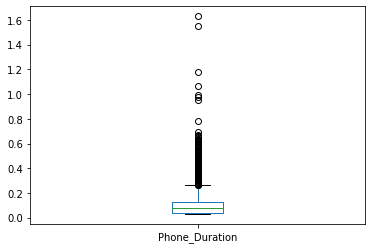

In [51]:
vowel_df.Phone_Duration.plot(kind = 'box')

So the vowel's being too long is more of an issue than them being too short

In [52]:
# 30 milliseconds
vowel_df.Phone_Duration.min()

0.029878689782975698

# Visualizing my data

## All data combined 

In [71]:
final_df.columns[6:-2]

Index(['Vowel', 'Speech_Sound', 'Approximant', 'Liquid', 'Nasal', 'Fricative',
       'Stop', 'Voiced'],
      dtype='object')

In [72]:
for col in final_df.columns[6:8]:
    print (f"{col} has {round(final_df[col].sum() / final_df.shape[0], 3)}% of items in dataset")

Vowel has 0.374% of items in dataset
Speech_Sound has 0.931% of items in dataset


In [73]:
for col in final_df.columns[9:-2]:
    print (f"{col} has {round(final_df[col].sum() / final_df.shape[0], 3)}%  of items in dataset")

Liquid has 0.078%  of items in dataset
Nasal has 0.093%  of items in dataset
Fricative has 0.157%  of items in dataset
Stop has 0.178%  of items in dataset
Voiced has 0.339%  of items in dataset


### Duration of each speaker

In [209]:
# getting total speaking time of each person
speaker_speak_time = final_df.groupby('Speaker')['Phone_Duration'].sum()

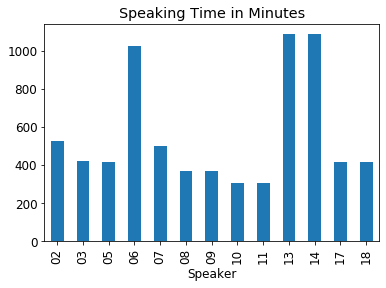

In [220]:
speaker_speak_time.plot(kind='bar', title = 'Speaking Time in Minutes')
plt.savefig('./Visualizations/Speaking_time_per_person.png')

### Pie chart showing DURATION of each class

In [192]:
final_df.columns

Index(['Phone_Text', 'Phone_xmin', 'Phone_xmax', 'Word_Text', 'Word_xmin',
       'Word_xmax', 'Vowel', 'Speech_Sound', 'Approximant', 'Liquid', 'Nasal',
       'Fricative', 'Stop', 'Voiced', 'Speaker', 'Phone_Duration'],
      dtype='object')

In [194]:
final_df.columns[9:-2]

Index(['Liquid', 'Nasal', 'Fricative', 'Stop', 'Voiced'], dtype='object')

In [195]:
all_data_class_counts = [final_df[final_df["Vowel"] == 1]['Phone_Duration'].sum()]
all_data_class_counts.extend([final_df[final_df[col] == 1]['Phone_Duration'].sum() for col in final_df.columns[8:-3]])

In [196]:
all_data_class_counts

[1105.5042606784532,
 87.4904598993189,
 184.4263929130919,
 240.73293315097226,
 398.74481114930643,
 468.3081590073539]

data_class_counts = [final_df[col].sum() for col in final_df.columns[6]]
all_data_class_counts = [final_df[final_df["Vowel"] == 1]['Phone_Duration'].sum() + \
[final_df[final_df[col] == 1]['Phone_Duration'].sum() for col in final_df.columns[9:-2]]]

In [197]:
# sum of speech sounds in audio 
(final_df.Phone_Duration.sum() - final_df[final_df['Speech_Sound'] == 1]['Phone_Duration'].sum()) /\
final_df.Phone_Duration.sum()

0.6526063124082427

In [157]:
# percent of non-speech duration that is in files
(final_df.Phone_Duration.sum() - final_df[final_df['Speech_Sound'] == 0]['Phone_Duration'].sum()) /\
final_df.Phone_Duration.sum()

0.34739368759175726

percent of elements that are non-speech sounds 
(final_df.shape[0] - final_df.Speech_Sound.sum()) / final_df.shape[0]

In [198]:
data_class_labels = [final_df.columns[6]] + list(final_df.columns[8:-3])
data_class_labels

['Vowel', 'Approximant', 'Liquid', 'Nasal', 'Fricative', 'Stop']

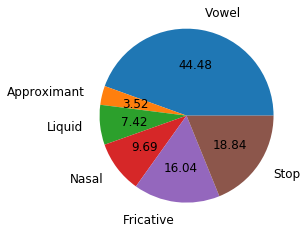

In [219]:
plt.pie(list(all_data_class_counts), labels = data_class_labels, autopct = '%.2f', labeldistance = 1.2)
plt.savefig('Minor_class_of_sounds.png')

### Pie chart show major classes

In [204]:
vow = [final_df[final_df["Vowel"] == 1]['Phone_Duration'].sum()]
vcd = [final_df[final_df["Voiced"] == 1]['Phone_Duration'].sum()]
vcless = [final_df[(final_df["Voiced"] == 0) & (final_df["Vowel"] == 0) & (final_df["Speech_Sound"] == 1)]['Phone_Duration'].sum()]
non_sp = [final_df[final_df["Speech_Sound"] == 0]['Phone_Duration'].sum()]

In [205]:
major_class_data = [vow, vcd, vcless, non_sp]

vowels, voiced, voiceless, non-speech
voiceless = final_df.shape[0] - sum(major_class_data) when major_class_data doesn't include the voiceless number
major_class_data = [final_df["Vowel"].sum(), final_df["Voiced"].sum(), 6346, final_df.shape[0] - final_df["Speech_Sound"].sum()]

In [206]:
major_class_labels = ['Vowel', 'Voiced', "Voiceless", "Non-Speech Sound"]

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """Entry point for launching an IPython kernel.


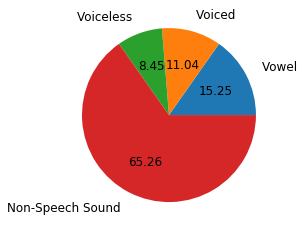

In [207]:
plt.pie(major_class_data, labels = major_class_labels, autopct = '%.2f', labeldistance = 1.2)
plt.savefig('Major_class_of_sounds.png')

# Getting acoustic data  

I won't be using duration to filter the vowels so it's a little useless to use duration as a filter. I think if I were to SEGMENT the vowels, then having a filter would be necessary. So if I WERE to filter the vowels at some point, I would need to use acoustic criteria that distinguishes vowels from consonants/semi-consonants

## Filtering data to only have speech sounds 

In [83]:
phoneme_df = final_df[final_df['Speech_Sound'] == 1]

In [84]:
phoneme_df.shape

(27056, 16)

## Testing absolute level of energy for each type of sound with in a sound file (02-06)

apparently the values are given in the scipy.io.wavefile.read command 
https://dsp.stackexchange.com/questions/37674/is-there-a-function-in-python-which-returns-the-amplitude-sound-pressure-level-o
i.e.: I have the values already from when I separated channels, I just need to calculate each one for a certain interval

So my file is in the "16-bit PCM" format. Therefore, my max values are +/- 32767

I could get away with downsampling to 11,025 sampling rate b/c only 8,000 is needed for human speech- https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Sampling_rate

In [85]:
enf_02_sound = wavfile.read("./split_wav_files_folder/ENF_02")

In [86]:
enf_02_sound[1].min()

-12887

In [87]:
enf_02_sound[1].shape

(11633672,)

In [88]:
type(enf_02_sound[1][0])

numpy.int16

So there are 22050 * 527.6 samples taken in the audio file. There are 527.6 seconds to the audio file. So each sample is 1/22050th of the audio file (i think. there might be some connection to the frequency measurement in there, too)

In [89]:
len(enf_02_sound[1]) / 22050

527.6041723356009

# Displays using librosa
https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

In [224]:
# I'm downsampling the data here to 8000 sr/max of 4000 Hz measurements (https://stackoverflow.com/questions/30619740/downsampling-wav-audio-file)
librosa_audio, sr = librosa.load("./original_en_diapix_data/DP_ENF_02_ENF_06_EN_ENF_02_DP_ENF_02_ENF_06_EN_ENF_06.wav", duration = 30, sr = 8000)

In [225]:
print(type(librosa_audio), type(sr))

<class 'numpy.ndarray'> <class 'int'>


### Waveform

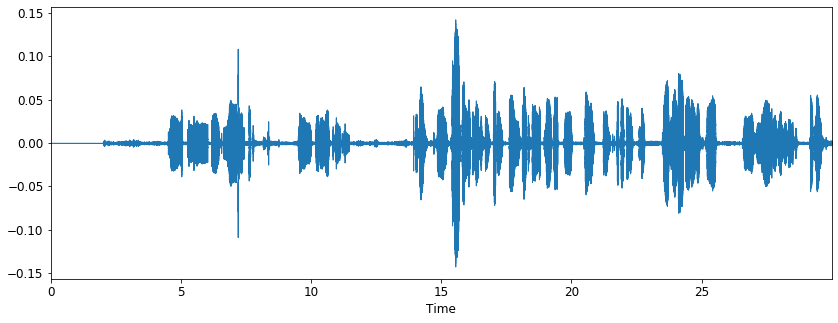

In [230]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(librosa_audio, sr=sr)
plt.savefig('./Visualizations/Example_Waveform.png')

### Spectrogram

This chart shows how much useless info I'm getting from the signal (everything above 5,000 Hz). Will definitely need to downsample

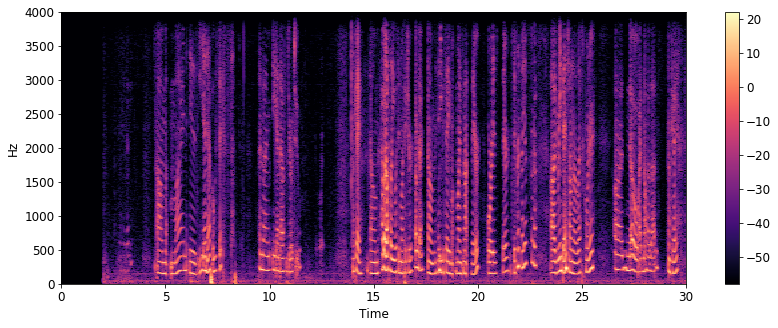

In [231]:
X = librosa.stft(librosa_audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.savefig('./Visualizations/Example_Spectrogram.png')

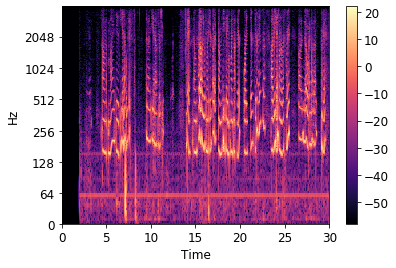

In [229]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### MFCC

(15, 469)


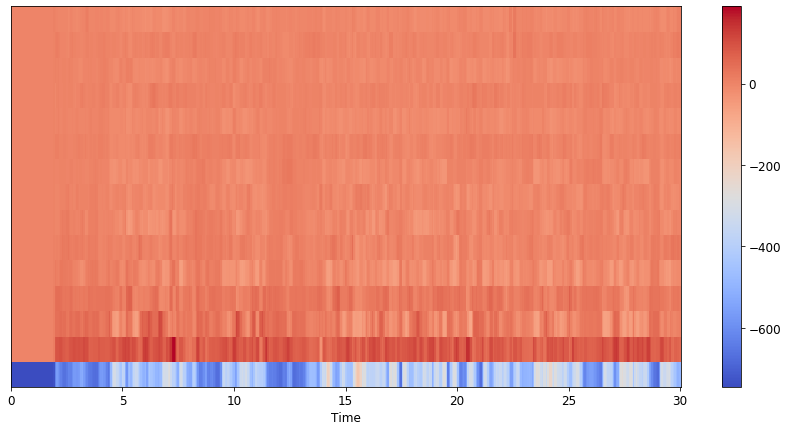

In [291]:
mfccs = librosa.feature.mfcc(librosa_audio, sr=sr, n_mfcc=15)
print(mfccs.shape)
(20, 97)
#Displaying  the MFCCs:
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()

# Testing using pitch tracking

In [4]:
pitch, mag = librosa.core.piptrack(librosa_audio, sr=8000, n_fft=512)
plt.imshow(pitch, aspect='auto')
plt.ylim([20,100])
plt.show()

NameError: name 'librosa' is not defined

# Using Hampel Filter
https://towardsdatascience.com/outlier-detection-with-hampel-filter-85ddf523c73d

In [ ]:
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [18]:
downsample_dictionary.keys()

dict_keys(['ENF_02', 'EN_05', 'EN_03', 'ENF_17', 'ENF_10', 'ENF_11', 'ENF_18', 'ENF_06', 'EN_06', 'EN_08', 'EN_09', 'EN_07', 'EN_14', 'EN_13', 'ENF_13', 'ENF_14'])

In [19]:
len(downsample_dictionary['ENF_02']['original']) / 8000

527.604125

In [20]:
len(downsample_dictionary['ENF_02']['Filter_25'][0]) / 8000

527.604125

In [21]:
(len(downsample_dictionary['ENF_02']['Filter_25'][1]) /  8000) * 25

178.6875

In [22]:
# so 34% of the file was considered to be voiced (i think)
178.6875 / 527.604125

0.3386772231926731

In [23]:
downsample_dictionary['ENF_02']['Filter_25'][1][50:55]

[32832, 32836, 34373, 37428, 37429]

In [24]:
# i'm still trying to figure out how exactly to interpret the results of my function...

In [25]:
16291 / 8000

2.036375

# Evaluating results of hampel filter

In [100]:
# find the index of the voiced speech and seeing how much of a match there is with the results 

In [26]:
# trying to see the values for the transformed audio and the index where it is considered to be voiced
first_voiced_moment = downsample_dictionary['ENF_02']['Filter_25'][1][0]

In [263]:
downsample_dictionary['ENF_02']['Filter_25'][0][first_voiced_moment]

-15.047568554299833

downsample_dictionary['ENF_02']['Filter_25'][0][first_voiced_moment - 100]

## First attempt at function

### Getting the indices of each point from df

In [265]:
sp_02 = final_df[final_df['Speaker'] == '02']
sp_02.head(2)

,Phone_Text,Phone_xmin,Phone_xmax,Word_Text,Word_xmin,Word_xmax,Vowel,Speech_Sound,Approximant,Liquid,Nasal,Fricative,Stop,Voiced,Speaker,Phone_Duration
0,NaN,0.0,2.000000,NaN,0.0,2.000000,0,0,0,0,0,0,0,0,02,2.000000
1,!SIL,2.0,9.457105,!SIL,2.0,9.457105,0,0,0,0,0,0,0,0,02,7.457105


In [105]:
for x in range(len(sp_02)):
    min_d = sp_02[['Phone_xmin', "Phone_xmax"][0]][x]
    max_d = sp_02[['Phone_xmin', "Phone_xmax"][1]][x]
    z = []
    for y in range(int((min_d)*8000), int(max_d*8000), 25):
        z.append((y, sp_02['Phone_Text'][x]))

In [106]:
z[0][0]/8000

525.604125

In [107]:
min_d = sp_02[['Phone_xmin', "Phone_xmax"][0]][0]
max_d = sp_02[['Phone_xmin', "Phone_xmax"][1]][0]
x = []
for y in range(int((min_d + 1)*8000), int(max_d*8000), 25):
    x.append((y, sp_02['Phone_Text'][x]))

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
for y in range(int((min_d + 1)*8000), int(max_d*8000), 25):
    x.append((y, sp_02['Phone_Text'][0]))

In [ ]:
possible_2_ranges = []
for x in range(0, int(527.604172 * 8000)):
    possible_2_ranges.append(x)

In [ ]:
# putting each item in correct spot in parallel possible 2 ranges list 
possible_2_ranges_label = []
for x in range(0, int(527.604172 * 8000)):
    for y in sp_02:
        if sp_02['Phone_xmax'][y] > (x/8000) > sp_02['Phone_xmin'][y]:
            possible_2_ranges_label.append(sp_02['Phone_Text'][y])

In [ ]:
possible_2_ranges_label = []
for x in range(0, int(527.604172 * 8000)):
    for y in sp_02:
        z = np.where(sp_02['Phone_xmax'][0] > (600/8000) > sp_02['Phone_xmin'][0], sp_02['Phone_Text'][0], "Whoops")  
        possible_2_ranges_label.append(z)

In [ ]:
def get_labels_at_sample(df = sp_02):
    possible_2_ranges_label = []
    phone_max = list(df['Phone_xmax'])
    phone_min = list(df['Phone_xmin'])
    phone_text = list(df['Phone_Text'])
   
    for y in range(len(df)):
        for x in range(0, int(527.604172 * 8000)):
            if phone_max[y] > (x/8000) > phone_min[y]:
                z = np.where(phone_max[y] > (x/8000) > phone_min[y], phone_text[y], "Whoops")  
                possible_2_ranges_label.append(z)
            else:
                break      
    return z

In [ ]:
z = get_labels_at_sample()

#### get_labels_at_sample numba version

In [ ]:
@jit(nopython=True)
def get_labels_at_sample_numba(phone_max = phone_max, phone_min = phone_min, phone_text = phone_text):
    possible_2_ranges_label = []
    z = None
    for y in range(len(phone_max)):
        for x in range(0, int(527.604172 * 8000)):
            if phone_max[y] > (x/8000) > phone_min[y]:
                z = np.where(phone_max[y] > (x/8000) > phone_min[y], phone_text[y], "Whoops")  
                possible_2_ranges_label.append(z)
            else:
                break      
    return possible_2_ranges_label

In [ ]:
phone_max1 = list(sp_02['Phone_xmax'])
phone_min1 = list(sp_02['Phone_xmin'])
phone_text1 = list(sp_02['Phone_Text'])
z = get_labels_at_sample(phone_max = phone_max1, phone_min = phone_min1, phone_text = phone_text1)

### Different Attempt at categorizing results

In [108]:
# i'll see if the points are in the intervals of voiced sounds
voiced_sp_02 = sp_02[sp_02['Voiced'] == 1]

In [110]:
for a in range(len(voiced_sp_02)):
    print(a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [111]:
actually_voiced = []
actually_voiceless = []
for x in downsample_dictionary['ENF_02']['Filter_25'][1]:
    for y in range(len(voiced_sp_02)):
        if voiced_sp_02['Phone_xmax'][y] >= x >= voiced_sp_02['Phone_xmin'][y]:
            actually_voiced.append(x)
        

NameError: name 'downsample_dictionary' is not defined

In [ ]:
actually_voiced

### Finding the threshold of volume for the first sound file to be considered voiced

In [ ]:
min2 = 100
max2 = 0
volume_list = []
for x in downsample_dictionary['ENF_02']['Filter_25'][1]:
    for y in downsample_dictionary['ENF_02']['Filter_25'][0][x-10:x+10]:
        _allvolume += abs(y)
    volume / 20
    if volume < min2:
        min2 = volume
    if volume > max2:
        max2 = volume
    volume_list.append(volume)

In [ ]:
min2

In [ ]:
max2

In [ ]:
sns.violinplot(x = volume_list)

In [ ]:
max(downsample_dictionary['ENF_02']['original'])

# Second attempt at making evaluating function

In [32]:
voiced_2_indices = downsample_dictionary['ENF_02']['Filter_25'][1]

In [33]:
voiced_2_times = [x/8000 for x in voiced_2_indices]

In [36]:
# make specific df
sp_2_vcd = final_df[(final_df['Speaker'] == '02') & (final_df['Voiced'] == 1)]

In [42]:
sp_2_vcd.reset_index(inplace= True)

start_time = time.time()
evaluate_filter_for_2 = []
for x in voiced_2_times[0:1000]:
    flag = False
    for y in range(len(sp_2_vcd)):
        flag = True
        if sp_2_vcd['Phone_xmax'][y] >= x >= sp_2_vcd['Phone_xmin'][y]:
            evaluate_filter_for_2.append(1)
    if flag == False:
        evaluate_filter_for_2.append(0)
end_time = time.time()
print(f"The function took {end_time - start_time} seconds")

### Trying to vectorize the checking results code
https://stackoverflow.com/questions/10062954/valueerror-the-truth-value-of-an-array-with-more-than-one-element-is-ambiguous

In [262]:
def check_ind_values(prediction, phone_max, phone_min):
    y = np.where((sp_2_vcd['Phone_xmax'].values >= prediction) & (prediction >= sp_2_vcd['Phone_xmin'].values), 1, 0)
    #it's somehow faster to do this rather than np.sum(y)
    if np.sum(y) == 1:
        return 1
    else:
        return 0

In [261]:
%%timeit
# using np.sum(y): 1.25 s ± 41.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
prediction_results = [check_ind_values(x, sp_2_vcd['Phone_xmax'], sp_2_vcd['Phone_xmin']) for x in voiced_2_times]

1.18 s ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [258]:
len(prediction_results[0])

475

In [137]:
downsample_dictionary.keys()

dict_keys(['ENF_02', 'EN_05', 'EN_03', 'ENF_17', 'ENF_10', 'ENF_11', 'ENF_18', 'ENF_06', 'EN_06', 'EN_08', 'EN_09', 'EN_07', 'EN_14', 'EN_13', 'ENF_13', 'ENF_14'])

In [286]:
def check_all_values(df, feature_to_check = "Vowel", speaker = "", downsample_dictionary = downsample_dictionary):
    # getting the key for the speaker
    participants = downsample_dictionary.keys()
    for x in participants:
        if speaker in x:
            dict_key = x
    # making predictions from frames into seconds
    predictions = (np.array(downsample_dictionary[dict_key]['Filter_25'][1])) / 8000
    
    # initializing values
    tp_pct = 0
    fp_pct = 0
#     fn = 0
    # breaking down the dataframe to the parts that I want
    small_df = df[(df[feature_to_check] == 1) & (df['Speaker'] == speaker)]
    xmax = small_df['Phone_xmax'].values
    xmin = small_df['Phone_xmin'].values
    #checking how many actual vowels/voiced segments were hit
    segment_success = np.zeros(len(xmin))
    for idx, x in enumerate(segment_success):
        for y in predictions:
            if xmin[idx] <= y <= xmax[idx]:
                segment_success[idx] = 1
                break
    segment_success_pct = np.count_nonzero(segment_success) / len(segment_success)
        
    #running the calculations
    prediction_results = np.array([check_ind_values(x, xmax, xmin) for x in predictions])

    # getting the total number of samples for the entire file
    predicted_ratio = len(downsample_dictionary[dict_key]['Filter_25'][1]) / len(downsample_dictionary[dict_key]['Filter_25'][0])
    # actual ratio
    actual_ratio = small_df['Phone_Duration'].sum() / (len(downsample_dictionary[dict_key]['Filter_25'][0]) / 8000)
    
    # i can count percent of prediction_results are in the intervals
    tp_pct = np.count_nonzero(prediction_results) / len(prediction_results)
    fp_pct = (len(prediction_results) - np.count_nonzero(prediction_results)) / len(prediction_results)
    
    results_dict = {"predicted_ratio":round(predicted_ratio, 4), "actual_ratio": round(actual_ratio, 4),
                    "tp_pct": round(tp_pct, 4), "fp_pct": round(fp_pct, 4), "segment_success_pct": round(segment_success_pct, 4)}
    return results_dict

In [287]:
test_dict = check_all_values(final_df, speaker = '02', feature_to_check = 'Voiced')

In [288]:
test_dict

{'predicted_ratio': 0.0135,
 'actual_ratio': 0.0891,
 'tp_pct': 0.2853,
 'fp_pct': 0.7147,
 'segment_success_pct': 0.8358}

#### Figuring out how to calculate percent correct

In [119]:
len(downsample_dictionary['ENF_02']['original']) / 8000

527.604125

In [131]:
sp_2_vcd.Phone_Duration.sum()

47.00734121489405

In [133]:
47/ 527

0.08918406072106262

In [135]:
# THE original sound file has 9% of the file voiced 
sp_2_vcd.Phone_Duration.sum() / (len(downsample_dictionary['ENF_02']['original']) / 8000)

0.0890958561305677

In [127]:
# i covered 15% of the voiced segments....i think
(len(downsample_dictionary['ENF_02']['Filter_25'][1]) * (1/8000)) / sp_2_vcd.Phone_Duration.sum()

0.15205071836173856

In [129]:
len(downsample_dictionary['ENF_02']['Filter_25'][0])

4220833

In [134]:
# The filter predicts the file to have 1.4% of the signal to be voiced
len(downsample_dictionary['ENF_02']['Filter_25'][1]) / len(downsample_dictionary['ENF_02']['Filter_25'][0])

0.013547088927706924

In [136]:
# i actually have 15% of the signal covered
## I should try this with a lower sigma and then use a classification model on top of this 
0.013547088927706924 / 0.08918406072106262

0.15190033755109678

# Testing different sigmas effect on segment_success_pct

## Running the filter sigma 3 window 25 on speaker 3

In [271]:
len(downsample_dictionary['EN_03']['Filter_25'][1])

14634

In [289]:
results_03 = check_all_values(final_df, speaker = '03' )

In [290]:
results_03

{'predicted_ratio': 0.0043,
 'actual_ratio': 0.0867,
 'tp_pct': 0.0807,
 'fp_pct': 0.9193,
 'segment_success_pct': 0.5392}